In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy import stats
import statistics
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error, make_scorer
import seaborn as sns
import os
from scipy.stats import skew, probplot, norm
import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, LassoCV, Lasso, ElasticNet 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

## xgboost on Aaron Data

In [2]:
#loading Aaron cleaned data, basement.csv
data = pd.read_csv('./Machine-Learning-Project-master/Fez/basement.csv')

#training data is rows with none zero sales price
training = data.loc[data.SalePrice!=0]
test_set = data.loc[data.SalePrice==0]



In [3]:
#X is training set without SalePrice
#y is training set is SalePrice
X = training.loc[:, training.columns !='SalePrice']
y = np.log(training[['SalePrice']])

In [4]:
#set up test and train split from the training data set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [5]:
#kfold for cross validation
kf = KFold(n_splits = 5, shuffle = True, random_state = 28)


In [6]:
#set up xgb with random parameter
xgb = XGBRegressor()
xgb.set_params(random_state=123)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [7]:
#fit X_train and y_train with xgb
xgb.fit(X_train, y_train)


[14:28:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [8]:
#get R^2 for the test and train set
print("The train set R^2 is: %.5f" % xgb.score(X_train, y_train))
print("The test set R^2 is is: %.5f" % xgb.score(X_test, y_test))

The train set R^2 is: 0.95504
The test set R^2 is is: 0.89569


In [9]:
# Initial prediction with the random parameters
xgb_pred = xgb.predict(X_test)

# Calculate the absolute errors
errors = abs(np.expm1(xgb_pred) - np.expm1(y_test).values)

# Print out MAE, MSE, and RMSE
print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, xgb_pred))
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(y_test, xgb_pred)))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / np.expm1(y_test).values)
print('Mean Absolute Percent Error (MAPE):', round(np.mean(mape), 2), '%.')

Mean Absolute Error (MAE): $ 77096.73
Mean Squared Error (MSE): 0.01653643639302307
Root Mean Square Error (RMSE): 0.1285940760417177
Mean Absolute Percent Error (MAPE): 48.38 %.


### random search xbgoost

In [10]:
#parameter tuning using randomsearch
xgb_param_grid ={'learning_rate': [0.01, 0.05, 0.1],
                 'max_depth': [2, 3, 4, 5, 6],
                 'min_child_weight': [4, 5, 6],
                 'n_estimators': [400, 450, 500, 550, 600]}

random_search_xgb = RandomizedSearchCV(xgb, xgb_param_grid, scoring='neg_mean_squared_error', 
                                     cv= kf, n_jobs=-1, return_train_score = True)

%time random_search_xgb.fit(X_train, y_train)

[14:30:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 7.8 s, sys: 96 ms, total: 7.9 s
Wall time: 2min 10s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=28, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1,...
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                                          verbosity=1),
                   iid='warn', n_iter=10, n_

In [11]:
#get best best parameters from random search
random_search_xgb.best_params_

{'n_estimators': 500,
 'min_child_weight': 6,
 'max_depth': 2,
 'learning_rate': 0.1}

In [12]:
random_xgb = random_search_xgb.best_estimator_

In [13]:
print("The train set R^2 is: %.5f" % random_xgb.score(X_train, y_train))
print("The test set R^2 is is: %.5f" % random_xgb.score(X_test, y_test))

The train set R^2 is: 0.97095
The test set R^2 is is: 0.91088


In [14]:
#Prediction with tuned hyperparameters
random_xgb_pred = random_xgb.predict(X_test)

# Calculate the absolute errors
errors = abs(np.expm1(random_xgb_pred) - np.expm1(y_test).SalePrice)

# Print out MAE, MSE, and RMSE
print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, random_xgb_pred))
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(y_test, random_xgb_pred)))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / np.expm1(y_test).SalePrice)
print('Mean Absolute Percent Error (MAPE):', round(np.mean(mape), 2), '%.')

Mean Absolute Error (MAE): $ 14392.43
Mean Squared Error (MSE): 0.014128242532043511
Root Mean Square Error (RMSE): 0.11886228389208879
Mean Absolute Percent Error (MAPE): 8.38 %.


In [15]:
#further fine tuning parameters

xgb_param_grid1 ={'learning_rate': [0.01],
                 'max_depth': [3],
                 'min_child_weight': [0],
                 'n_estimators': [3460],
                 'subsample': [0.7],
                 'colsample_bytree' : [0.7],
                 'objective':['reg:linear'],
                 'nthread':[-1],
                 'scale_pos_weight':[1],
                 'seed':[27],
                 'reg_alpha': [0.00006]}

random_search_xgb1 = RandomizedSearchCV(xgb, xgb_param_grid1, scoring='neg_mean_squared_error', 
                                     n_jobs=-1, return_train_score = True)

%time random_search_xgb1.fit(X_train, y_train)                 


[14:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 47.7 s, sys: 32.7 ms, total: 47.7 s
Wall time: 1min 22s


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          rand...
                   param_distributions={'colsample_bytree': [0.7],
                                        'learning_rate': [0.01],
                                        'max_depth': [3],

In [16]:
random_search_xgb1.best_params_

{'subsample': 0.7,
 'seed': 27,
 'scale_pos_weight': 1,
 'reg_alpha': 6e-05,
 'objective': 'reg:linear',
 'nthread': -1,
 'n_estimators': 3460,
 'min_child_weight': 0,
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bytree': 0.7}

In [17]:
random_xgb1 = random_search_xgb1.best_estimator_

In [18]:
print("The train set R^2 is: %.5f" % random_xgb1.score(X_train, y_train))
print("The test set R^2 is is: %.5f" % random_xgb1.score(X_test, y_test))

The train set R^2 is: 0.98616
The test set R^2 is is: 0.91220


In [19]:
# Train Data
random_xgb_pred1 = random_xgb1.predict(X_train)

# Calculate the absolute errors
errors = abs(np.expm1(random_xgb_pred1) - np.expm1(y_train).values)

# Print out MAE, MSE, and RMSE
print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
print('Mean Squared Error (MSE):', mean_squared_error(y_train, random_xgb_pred1))
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(y_train, random_xgb_pred1)))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / np.expm1(y_train).values)
print('Mean Absolute Percent Error (MAPE):', round(np.mean(mape), 2), '%.')

Mean Absolute Error (MAE): $ 80979.66
Mean Squared Error (MSE): 0.002212686460427614
Root Mean Square Error (RMSE): 0.04703920131579207
Mean Absolute Percent Error (MAPE): 49.26 %.


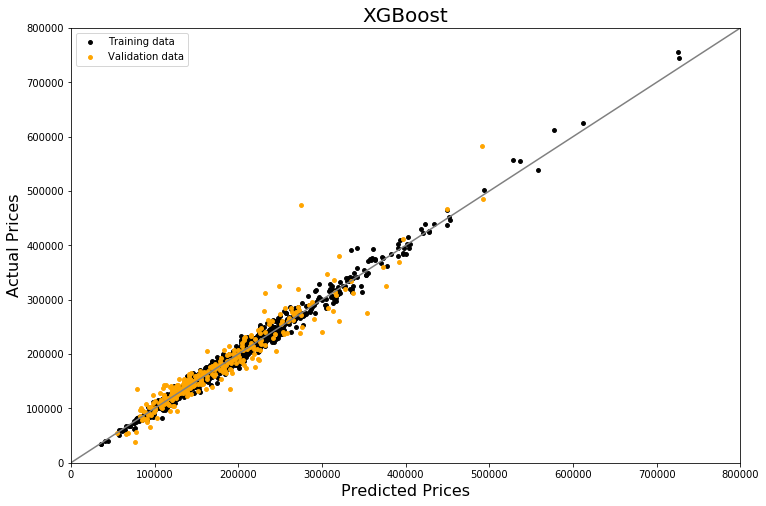

In [20]:
y_train_xgboost = random_xgb1.predict(X_train)
y_test_xgboost = random_xgb1.predict(X_test)

# Plot predictions
plt.figure(figsize=(12,8))
plt.scatter(np.expm1(y_train_xgboost), np.expm1(y_train), c='black', marker="o", s=15, label = "Training data")
plt.scatter(np.expm1(y_test_xgboost), np.expm1(y_test), c='orange', marker='o', s=15, label = "Validation data")
plt.title("XGBoost", fontsize = 20)
plt.xlabel("Predicted Prices", fontsize = 16)
plt.ylabel("Actual Prices", fontsize = 16)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.legend(loc = "upper left")
plt.plot([0, 800000], [0, 800000], c = "grey")
plt.show()

In [21]:

# Get numerical feature importances
importances_xgb = list(xgb.feature_importances_)

# List of tuples with variable and importance
feature_importances_xgb = [(feature, round(importance, 5)) for feature, importance in zip(X_train.columns, importances_xgb)]

# Sort the feature importances by most important first
xgb_feature_importances = sorted(feature_importances_xgb, key = lambda x: x[1], reverse = True )

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in xgb_feature_importances]

Variable: ExterQual__TA        Importance: 0.12094999849796295
Variable: KitchenQual__TA      Importance: 0.07666999846696854
Variable: GarageCars           Importance: 0.0723700001835823
Variable: GarageType__Attchd   Importance: 0.06385999917984009
Variable: YearBuilt            Importance: 0.05065000057220459
Variable: Fireplaces           Importance: 0.04805999994277954
Variable: BsmtQual__Ex         Importance: 0.04413999989628792
Variable: GrLivArea            Importance: 0.041200000792741776
Variable: CentralAir__N        Importance: 0.03891000151634216
Variable: TotalBsmtSF          Importance: 0.037769999355077744
Variable: GarageArea           Importance: 0.035429999232292175
Variable: GarageCond__TA       Importance: 0.025909999385476112
Variable: KitchenQual__Ex      Importance: 0.01730000041425228
Variable: MSZoning__RM         Importance: 0.016130000352859497
Variable: YearRemodAdd         Importance: 0.014890000224113464
Variable: MSZoning__RL         Importance: 0.01413

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [22]:
xgb_feature_importances_top20 = xgb_feature_importances[:20]
featureNames, featureScores = zip(*list(xgb_feature_importances_top20))

Text(0.5, 1.0, 'Feature Importances')

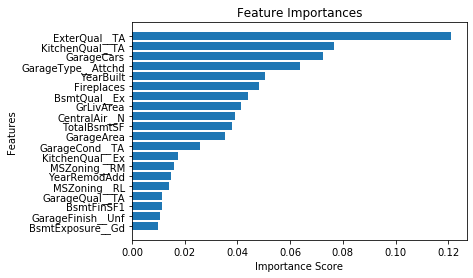

In [23]:
plt.barh(range(len(featureScores)), featureScores, tick_label=featureNames)
plt.gca().invert_yaxis()
plt.title('feature importance')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importances')

In [24]:
train_predicted_price = np.expm1(random_xgb1.predict(X))

In [25]:
X['train_predicted_price'] = train_predicted_price

In [26]:
X['SalePrice'] = np.expm1(y)

In [27]:
trainset_updated_predicted_price = X


In [28]:
trainset_updated_predicted_price.to_csv('trainset_updated_predicted_price.csv')


In [29]:
trainset_updated_predicted_price.sample(5)

Id  LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  \
1125  1127     53.00000     3684       2007          2007       130.0   
1279  1281     67.00000     9808       2002          2002       110.0   
1086  1088     85.00000    10574       2005          2006         0.0   
116    117     74.55102    11616       1962          1962       116.0   
1038  1040     21.00000     1477       1970          1970         0.0   

      BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF    ...      \
1125         0.0         0.0     1373.0       1373.0    ...       
1279       788.0         0.0      785.0       1573.0    ...       
1086         0.0         0.0     1082.0       1082.0    ...       
116        170.0       670.0      252.0       1092.0    ...       
1038       509.0         0.0      121.0        630.0    ...       

      SaleType__Oth  SaleType__WD  SaleCondition__Abnorml  \
1125              0             1                       0   
1279              0             1                       0   
1086              0             1                       0   
116               0             1                       0   
1038              0             1                       0   

      SaleCondition__AdjLand  SaleCondition__Alloca  SaleCondition__Family  \
1125                       0                      0                      0   
1279                       0                      0                      0   
1086                       0                      0                      0   
116                        0                      0                      0   
1038                       0                      0                      0   

      SaleCondition__Normal  SaleCondition__Partial  train_predicted_price  \
1125                      1                       0          201260.890625   
1279                      1                       0          214802.343750   
1086                      1                       0          250426.890625   
116                       1                       0          119058.640625   
1038                      1                       0           81107.195312   

      SalePrice  
1125   173999.0  
1279   226999.0  
1086   251999.0  
116    138999.0  
1038    79999.0  

[5 rows x 417 columns]

In [30]:
#drop SalePrice column from test_set
test_set = training.loc[:, training.columns !='SalePrice']


In [31]:
test_set['predicted_Sale_Price'] = random_xgb1.predict(test_set)

In [32]:

test_set.to_csv('test_set_updated_predicted_price.csv')
